# Análisis gráfico

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

## Cargar los datos del archivo `data.csv`

In [2]:
# Cargar el dataset desde el archivo CSV
file_path = "../data/raw/data.csv"
df = pd.read_csv(file_path, header=None)

In [3]:
# Crear nombres cortos para las características
feature_names = [f'feat{str(i+1).zfill(2)}' for i in range(30)]

# Eliminar columna ID
df = df.drop([0], axis=1)  # El ID no aporta información

# Asignar nombres cortos a las columnas de características
df.columns = ['diagnosis'] + feature_names  # Concatenamos la lista

## Gráfico de violín
- Un **gráfico de violín** es una herramienta visual utilizada en estadística para representar la distribución de un conjunto de datos.  
- Combina elementos de un diagrama de caja (*box plot*) y un gráfico de densidad (*density plot*), lo que permite visualizar no solo la mediana y los cuartiles, sino también la forma completa de la distribución de los datos.
- Muestra la distribución de los datos a lo largo de diferentes valores, donde el ancho del "violín" representa la frecuencia o densidad de los datos en ese punto.  
- En el centro se representan unas divisiones que son los cuartiles. La división centrl es la mediana.

####  Características de un gráfico de violín:
1. **Forma de violín**: La forma del gráfico se asemeja a un violín, con un ancho que varía según la densidad de los datos en diferentes valores.
2. **Eje vertical**: Representa los valores de la variable que se está analizando.
3. **Eje horizontal**: Suele representar categorías o grupos (si se están comparando múltiples distribuciones).
4. **Densidad**: El ancho del violín en cada punto indica la densidad de los datos en ese valor. Un área más ancha significa que hay más datos en ese rango.
5. **Mediana y cuartiles**: A menudo se superpone un diagrama de caja dentro del violín para mostrar la mediana (línea central) y los cuartiles (extremos de la caja).

---

#### Cómo interpretar un gráfico de violín:
1. **Forma de la distribución**:
   - Si el violín es simétrico, la distribución de los datos es probablemente normal.
   - Si es asimétrico, indica que la distribución está sesgada hacia la izquierda o la derecha.
   - Si tiene múltiples picos, sugiere que hay múltiples modas en los datos.

2. **Densidad de los datos**:
   - Las áreas más anchas indican rangos de valores con mayor frecuencia.
   - Las áreas más estrechas indican rangos de valores con menor frecuencia.

3. **Comparación entre grupos**:
   - Si hay múltiples violines, puedes comparar las distribuciones de diferentes grupos o categorías.
   - Observa diferencias en la mediana, la dispersión y la forma de las distribuciones.

4. **Valores atípicos**:
   - Aunque no se muestran explícitamente, los valores atípicos pueden inferirse si hay áreas muy estrechas en los extremos del violín.

---

#### Ejemplo de uso:
Supongamos que tienes datos sobre las alturas de personas en dos ciudades diferentes. Un gráfico de violín te permitiría:
- Ver si las distribuciones de alturas son similares o diferentes.
- Identificar si una ciudad tiene una distribución más concentrada o dispersa.
- Comparar las medianas y la variabilidad entre ambas ciudades.

En resumen, el gráfico de violín es una herramienta poderosa para entender la distribución de los datos de manera más detallada que un simple diagrama de caja o un histograma.

### *Widget* interactivo para elegir los datos normalizados
- Para crear el gráfico de violín es muy recomendable utilizar datos normalizados para evitar la extrema variabilidad entre los datos de las 30 características que habrían que el gráfico no se pudiera mostrar adecuadamente.
- Disponemos de cuatro tipos de normalización que podemos elegir con un *widget* interactivo.

In [4]:
# Crear el widget de selección con los nombres exactos de los archivos
normalization_selector = widgets.Dropdown(
    options=['zscore', 'minmax', 'robust', 'log'],
    value='zscore',
    description='Normalización:',
    style={'description_width': 'initial'}
)

# Mostrar el widget
display(normalization_selector)

Dropdown(description='Normalización:', options=('zscore', 'minmax', 'robust', 'log'), style=DescriptionStyle(d…

### Normalizar características de forma independiente o conjunta
- Esta decisión depende del contexto y los objetivos del análisis.
- Pros y contras de cada enfoque:

**Normalización independiente por característica (caso 'log'):**
* Pros:
  - Cada característica se escala a un rango comparable
  - Preserva mejor las diferencias relativas dentro de cada característica
  - Puede ser más útil para visualización y comparación de distribuciones
  - Ideal cuando las características representan medidas diferentes

* Contras:
  - Se pierde la información sobre las magnitudes relativas entre características
  - Puede ocultar cuáles características son más dominantes en términos absolutos
  - Podría no ser apropiado cuando la escala relativa entre características es importante

**Normalización conjunta (resto de casos):**
* Pros:
  - Mantiene las relaciones de magnitud entre diferentes características
  - Preserva la información sobre qué características tienen mayor variabilidad
  - Más apropiado cuando las características están en unidades similares o relacionadas

* Contras:
  - Las características con valores más grandes pueden dominar el análisis
  - Puede hacer que algunas características parezcan insignificantes en comparación

**En el caso específico de nuestro dataset:**
1. Para visualización: La normalización independiente (como se hace con log) tiene sentido porque el objetivo es comparar las distribuciones de cada característica.
2. Para el entrenamiento del modelo:
   - Si las características representan medidas diferentes (como parece ser el caso), la normalización independiente podría ser más apropiada
   - Si las características están relacionadas y sus magnitudes relativas son importantes, la normalización conjunta sería mejor

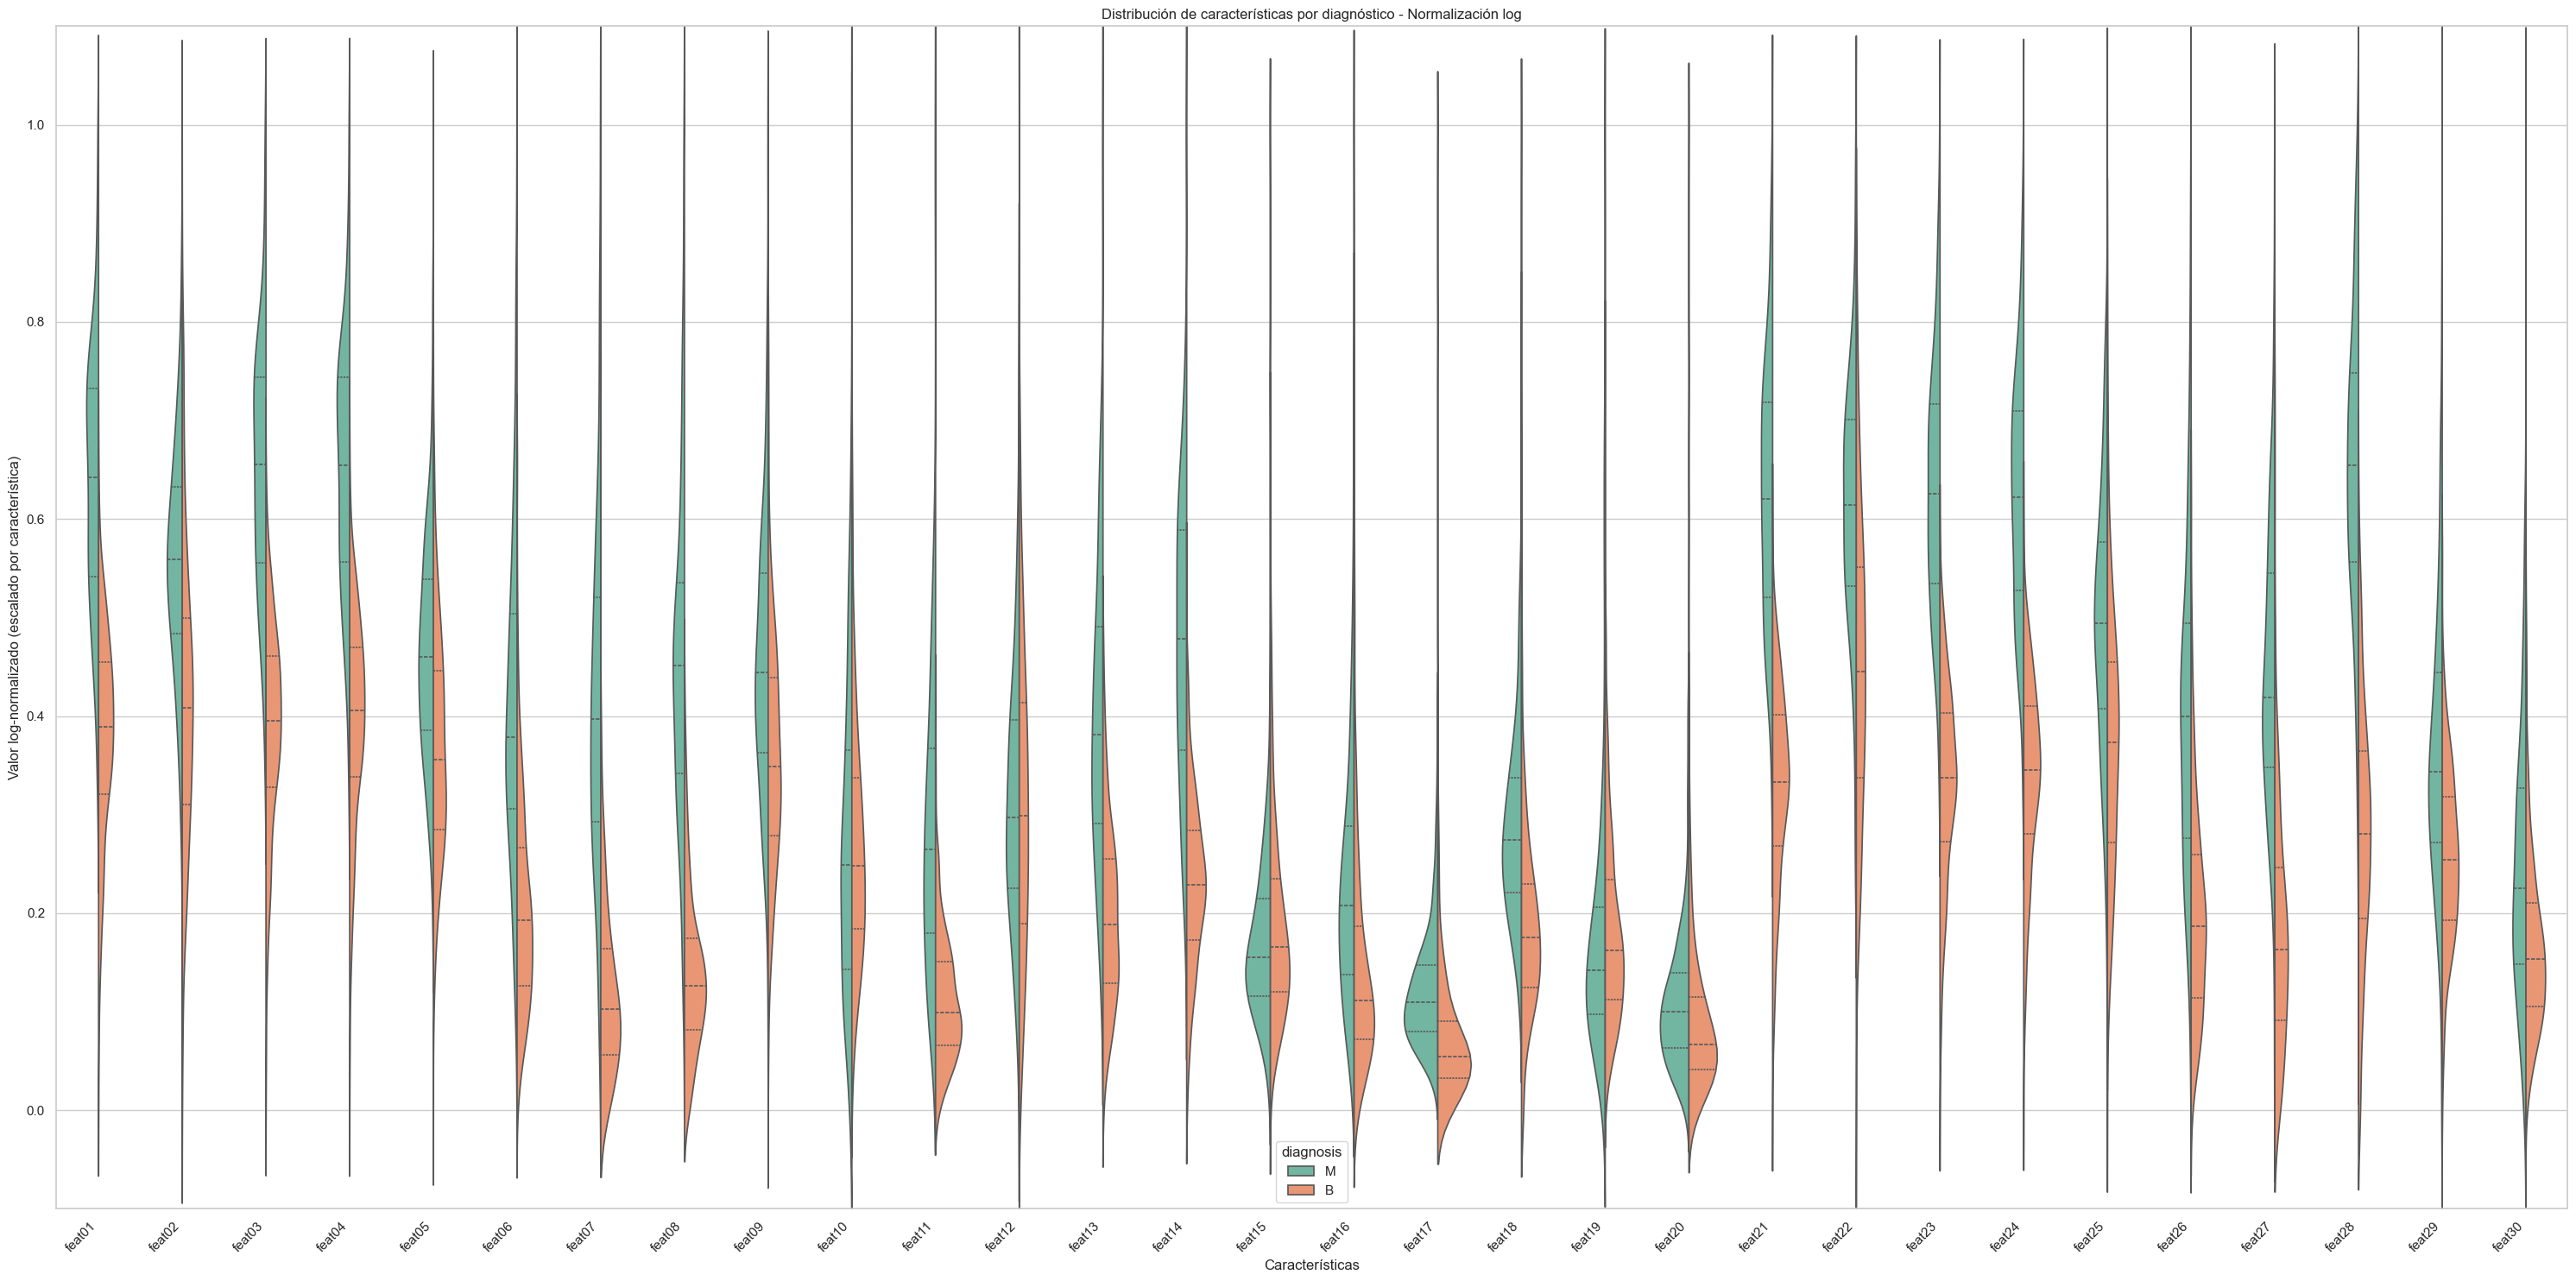

In [16]:
# Obtener el método de normalización seleccionado
selected_normalization = normalization_selector.value

# Cargar datos normalizados según la selección
df_normalized = pd.read_csv(f"../data/processed/{selected_normalization}_normalized.csv")

# Mapear diagnóstico de nuevo a M/B para visualización
df_normalized['diagnosis'] = df_normalized['diagnosis'].map({0: 'M', 1: 'B'})

# Convertir los datos al formato largo
df_melted = pd.melt(df_normalized, 
                    id_vars=['diagnosis'],
                    value_vars=[col for col in df_normalized.columns if col != 'diagnosis'],
                    var_name='features',
                    value_name='value')

# Crear el gráfico
plt.figure(figsize=(30, 15))

if selected_normalization == 'log':
    # Normalizar cada característica independientemente
    df_melted['value'] = df_melted.groupby('features')['value'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    
    # Crear el violin plot con los datos normalizados por característica
    sns.violinplot(x='features', 
                   y='value', 
                   hue='diagnosis',
                   data=df_melted,
                   split=True,
                   inner='quart',
                   palette='Set2')
    plt.ylabel('Valor log-normalizado (escalado por característica)')
    plt.ylim([-0.1, 1.1])
else:
    # Para el resto usamos una normalización conjunta de características
    sns.violinplot(x='features', 
                   y='value', 
                   hue='diagnosis',
                   data=df_melted,
                   split=True,
                   inner='quart',
                   palette='Set2')
    plt.ylabel('Valor normalizado')
    
    # Ajustar los límites del eje Y según el método
    if selected_normalization == 'minmax':
        plt.ylim([-0.1, 1.1])
    elif selected_normalization in ['zscore', 'robust']:
        plt.ylim([-4, 4])

# Configuración común del gráfico
plt.xticks(rotation=45, ha='right')
plt.title(f'Distribución de características por diagnóstico - Normalización {selected_normalization}')
plt.xlabel('Características')

# Ajustar el layout
plt.tight_layout()

# Guardar el gráfico antes de mostrarlo
plt.savefig(f'../output/figures/violin_plot_{selected_normalization}.png', dpi=300, bbox_inches='tight')
plt.show()

### Comentario al Gráfico de violín
Este es un gráfico de violín dividido: en el que la **parte izquierda** del violín representa la distribución de una categoría (en este caso, "M" para maligno) y la **parte derecha** representa la distribución de otra categoría ("B" para benigno). Este tipo de visualización es muy útil para comparar dos distribuciones de manera directa y visualmente intuitiva.

#### Interpretación del gráfico de violín dividido:
1. **Forma de las distribuciones**:
   - La forma de cada lado del violín muestra la densidad de los datos para cada categoría ("M" y "B").
   - Si un lado es más ancho que el otro, indica que hay más datos en ese rango de valores para esa categoría.

2. **Moda de las distribuciones**:
   - La **moda** es el punto más ancho del violín, ya que representa el valor con mayor densidad de datos.
   - Si las modas de "M" y "B" están alejadas en el gráfico, significa que los valores más frecuentes para cada categoría son diferentes. Esto sugiere que la variable analizada tiene un poder discriminativo entre las dos clases.
   - Por ejemplo, si la moda de "M" está en un valor más alto que la de "B", podría indicar que los casos malignos tienden a tener valores más altos en esa variable.

3. **Superposición de las distribuciones**:
   - Si las distribuciones de "M" y "B" se superponen significativamente, significa que hay un solapamiento en los valores de la variable para ambas categorías. Esto podría dificultar la clasificación.
   - Si hay poca superposición, la variable es más útil para distinguir entre "M" y "B".

4. **Dispersión de los datos**:
   - Si un lado del violín es más estrecho, indica que los datos están más concentrados alrededor de la moda.
   - Si es más ancho, sugiere una mayor dispersión de los datos.

5. **Asimetría**:
   - Si un lado del violín es asimétrico (por ejemplo, más largo hacia la derecha), indica que la distribución está sesgada hacia valores más altos o más bajos.

---

#### Ejemplo de interpretación:
Supongamos que estás analizando una variable como el "radio medio" de tumores en el dataset de cáncer de mama. En el gráfico de violín dividido:
- Si la moda de "M" está a la derecha de la moda de "B", significa que los tumores malignos tienden a tener un radio medio mayor que los benignos.
- Si las distribuciones están bien separadas (poca superposición), esta variable será muy útil para clasificar tumores como "M" o "B".
- Si hay mucha superposición, la variable por sí sola no será suficiente para distinguir entre las dos clases, y será necesario combinar varias variables en un modelo de Red Neuronal Profunda.

---

#### Implicaciones para la Red Neuronal Profunda:
- Si las modas están alejadas y hay poca superposición, es probable que la Red Neuronal pueda aprender a clasificar fácilmente las dos categorías usando esa variable.
- Si las distribuciones se superponen mucho, la Red Neuronal necesitará combinar múltiples variables para lograr una clasificación precisa.
- Este tipo de gráfico te ayuda a identificar qué variables son más prometedoras para la clasificación y cuáles podrían ser menos útiles.

En resumen, este gráfico de violín dividido es una excelente herramienta para explorar y comparar distribuciones de dos categorías, lo que te ayudará a entender mejor los datos y a diseñar un modelo de Red Neuronal más efectivo.

### Análisis el gráfico del WBCD
El gráfico incluye:
- División del violín por diagnóstico (split=True)
- Visualización de cuartiles dentro del violín (inner='quart')
- Uso de colores diferentes para M y B con una leyenda
- La asimetría en los violines ahora será visible, mostrando las diferencias en la distribución entre casos malignos y benignos

1. La normalización ha funcionado correctamente ya que todos los datos están centrados alrededor de 0 y mayoritariamente entre -2 y 2 desviaciones estándar.
2. La mayoría de las características muestran una distribución bimodal (dos "bultos" en el violín), lo que sugiere una separación natural entre las clases benignas y malignas.
3. Algunas características como feat13, feat14 y feat24 muestran valores atípicos significativos (las líneas delgadas que se extienden hasta valores de 8-12), lo que podría indicar casos especialmente graves o mediciones inusuales.
4. La forma y anchura variada de los violines indica que diferentes características tienen distintos patrones de distribución, lo que sugiere que aportan información única y potencialmente valiosa para la clasificación.
5. Permite ver directamente cómo se distribuyen los valores para cada clase
6. La asimetría en los violines muestra las diferencias en la forma de la distribución entre casos malignos y benignos
7. Los cuartiles internos proporcionan información estadística adicional

##  Gráfico de dispersión con ruido (stripplot)
- Un tipo de gráfico de dispersión que muestra la distribución de puntos individuales para variables categóricas.
- Cada punto representa una observación individual, y el "jitter" (dispersión horizontal aleatoria) ayuda a evitar la superposición de puntos y permite ver mejor la distribución de los datos.
- El *"jitter"* (que es el término técnico en inglés) se refiere a una perturbación o ruido aleatorio que se añade a los puntos para evitar la superposición.

Ventajas de este gráfico:
- Muestra cada punto individual, a diferencia del violin plot que muestra densidades
- El `jitter` horizontal permite ver la distribución real de los datos
- La transparencia ayuda a identificar áreas de alta densidad
- Complementa muy bien al violin plot, ya que muestra los datos reales vs la distribución

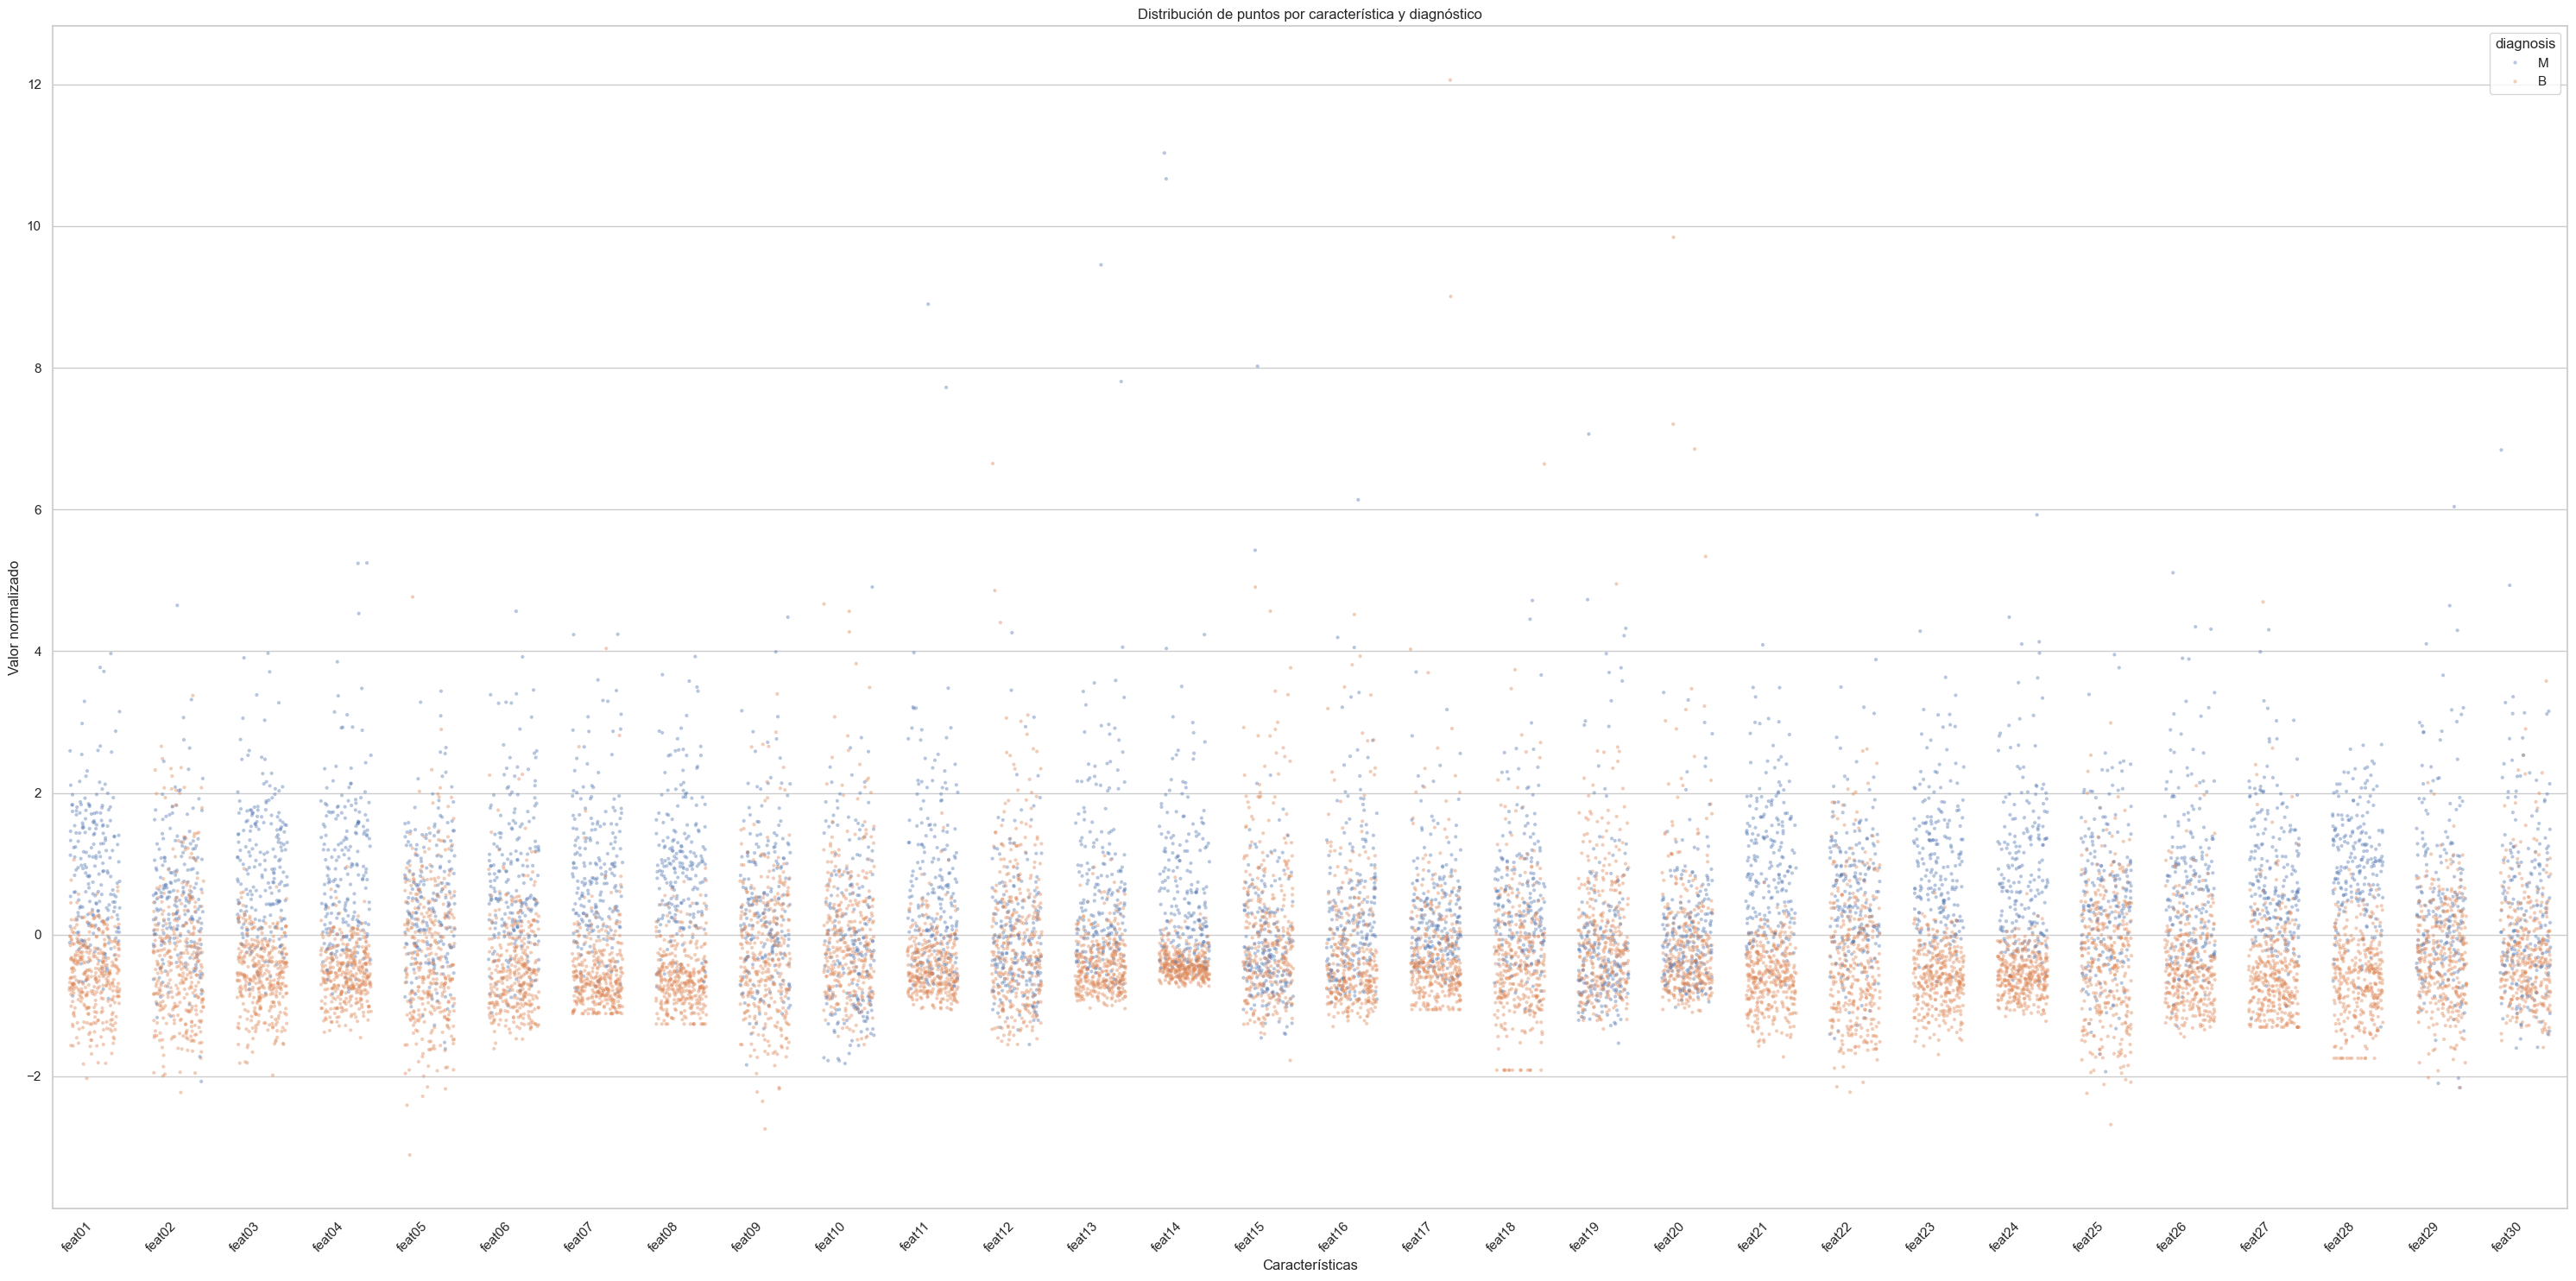

In [6]:
# Convertir los datos al formato largo (necesario para seaborn)
df_melted = pd.melt(df_normalized, 
                    id_vars=['diagnosis'],
                    value_vars=feature_names,
                    var_name='features',
                    value_name='value')

# Configurar el estilo
sns.set(style="whitegrid")

# Crear el gráfico usando stripplot
plt.figure(figsize=(30, 15))
sns.stripplot(x='features', 
              y='value', 
              hue='diagnosis',
              data=df_melted,
              size=3,
              jitter = 0.3,
              alpha=0.4)    # Hace los puntos semitransparentes


# Configurar el gráfico
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de puntos por característica y diagnóstico')
plt.xlabel('Características')
plt.ylabel('Valor normalizado')

# Ajustar el layout
plt.tight_layout()
plt.show()

### Análisis el gráfico de enjambre
1. Separación de clases:
- Se observa una clara separación entre células benignas (B) y malignas (M) en varias características
- Las características relacionadas con "worst" (feat21-feat30) muestran una separación más marcada, lo que sugiere que podrían ser buenos predictores para la clasificación

2. Distribución de valores:
- La mayoría de las características tienen valores normalizados entre -2 y 2
- Hay varios valores atípicos (outliers) que se extienden más allá de estos límites
- Las células malignas (M) tienden a mostrar valores más altos en muchas características

3. Patrones interesantes:
- Algunas características muestran una superposición significativa entre B y M, lo que sugiere que por sí solas podrían no ser tan útiles para la clasificación
- Otras características muestran una clara separación, lo que las hace potencialmente más valiosas para el diagnóstico
- La densidad de puntos varía entre características, indicando diferentes niveles de variabilidad en las mediciones

Este gráfico complementa bien al gráfico violinplot, ya que nos permite ver la distribución real de los puntos individuales en lugar de solo las densidades agregadas.

## Visualizar la distribución de algunas características antes y después de la estandarización

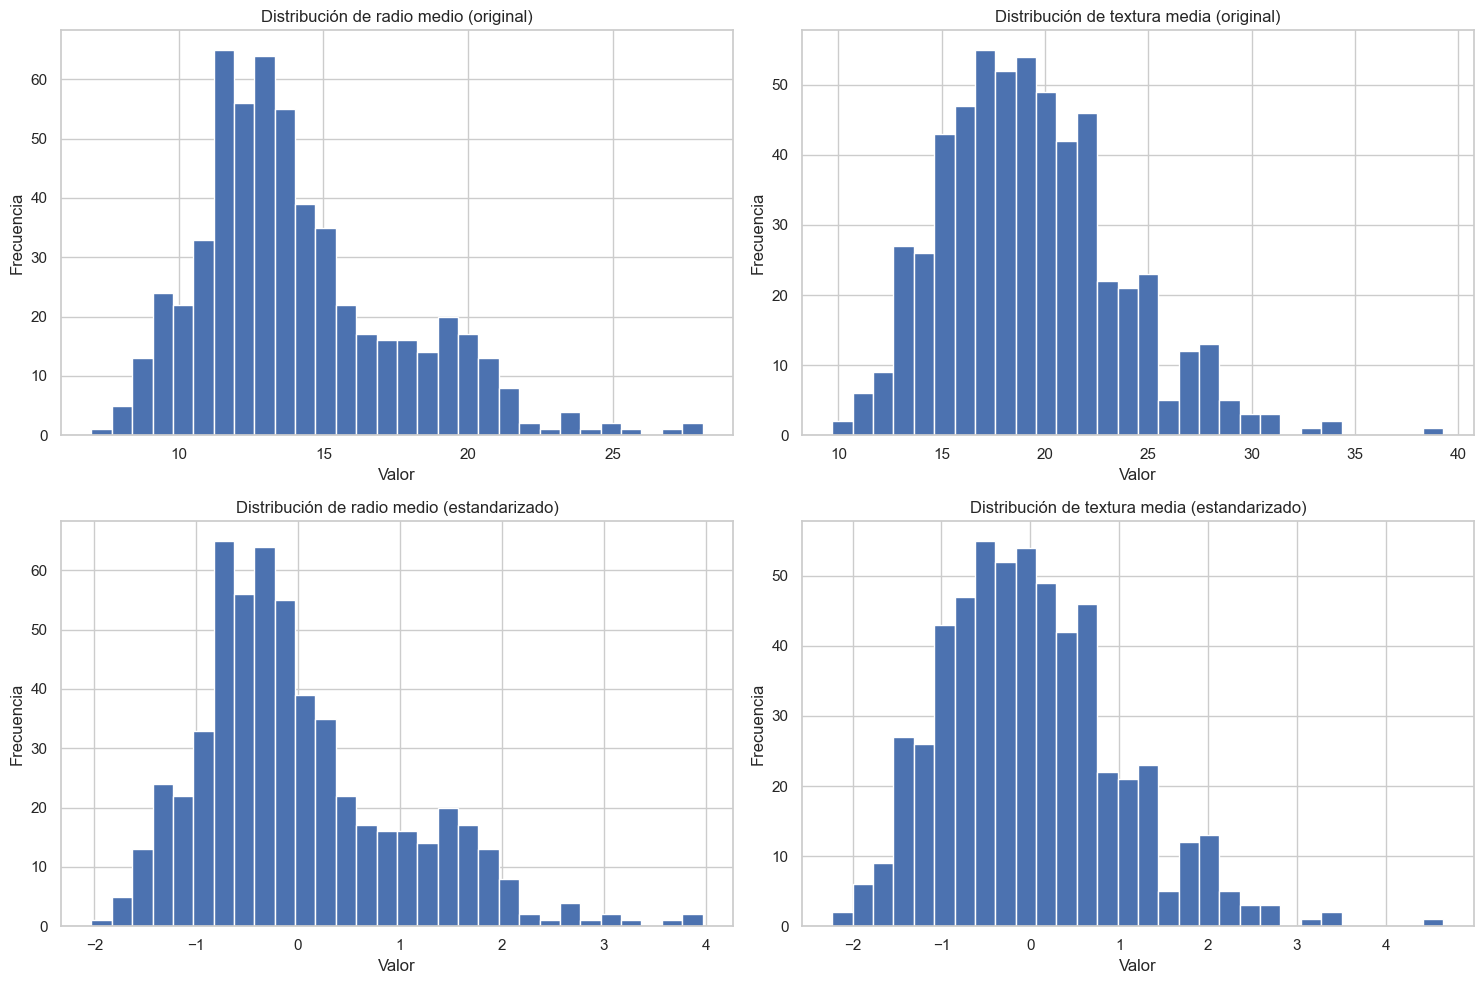

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Antes de la estandarización
axes[0,0].hist(df['feat01'], bins=30)
axes[0,0].set_title('Distribución de radio medio (original)')
axes[0,0].set_xlabel('Valor')
axes[0,0].set_ylabel('Frecuencia')

axes[0,1].hist(df['feat02'], bins=30)
axes[0,1].set_title('Distribución de textura media (original)')
axes[0,1].set_xlabel('Valor')
axes[0,1].set_ylabel('Frecuencia')

# Cargar datos estandarizados (z-score)
df_scaled = pd.read_csv("../data/processed/zscore_normalized.csv")

# Después de la estandarización
axes[1,0].hist(df_scaled['feat01'], bins=30)
axes[1,0].set_title('Distribución de radio medio (estandarizado)')
axes[1,0].set_xlabel('Valor')
axes[1,0].set_ylabel('Frecuencia')

axes[1,1].hist(df_scaled['feat02'], bins=30)
axes[1,1].set_title('Distribución de textura media (estandarizado)')
axes[1,1].set_xlabel('Valor')
axes[1,1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

### Comentarios sobre los gráficos
- Los gráficos superiores muestran la distribución de los datos ORIGINALES, mientras que los inferiores muestran los datos ESTANDARIZADOS.
- La forma de las distribuciones se mantiene idéntica entre los gráficos superiores e inferiores, variando únicamente la escala horizontal. Esto comprueba que la estandarización no altera la distribución relativa de los datos.
- Se puede ver que en los datos estandarizados la media es cero y hay datos negativos y positivos.
- Las frecuencias (alturas de barras) son idénticas entre los gráficos superiores e inferiores, ya que la estandarización solo afecta a la escala de los valores, no a su frecuencia de aparición.

## Matriz de Correlación con Heatmap

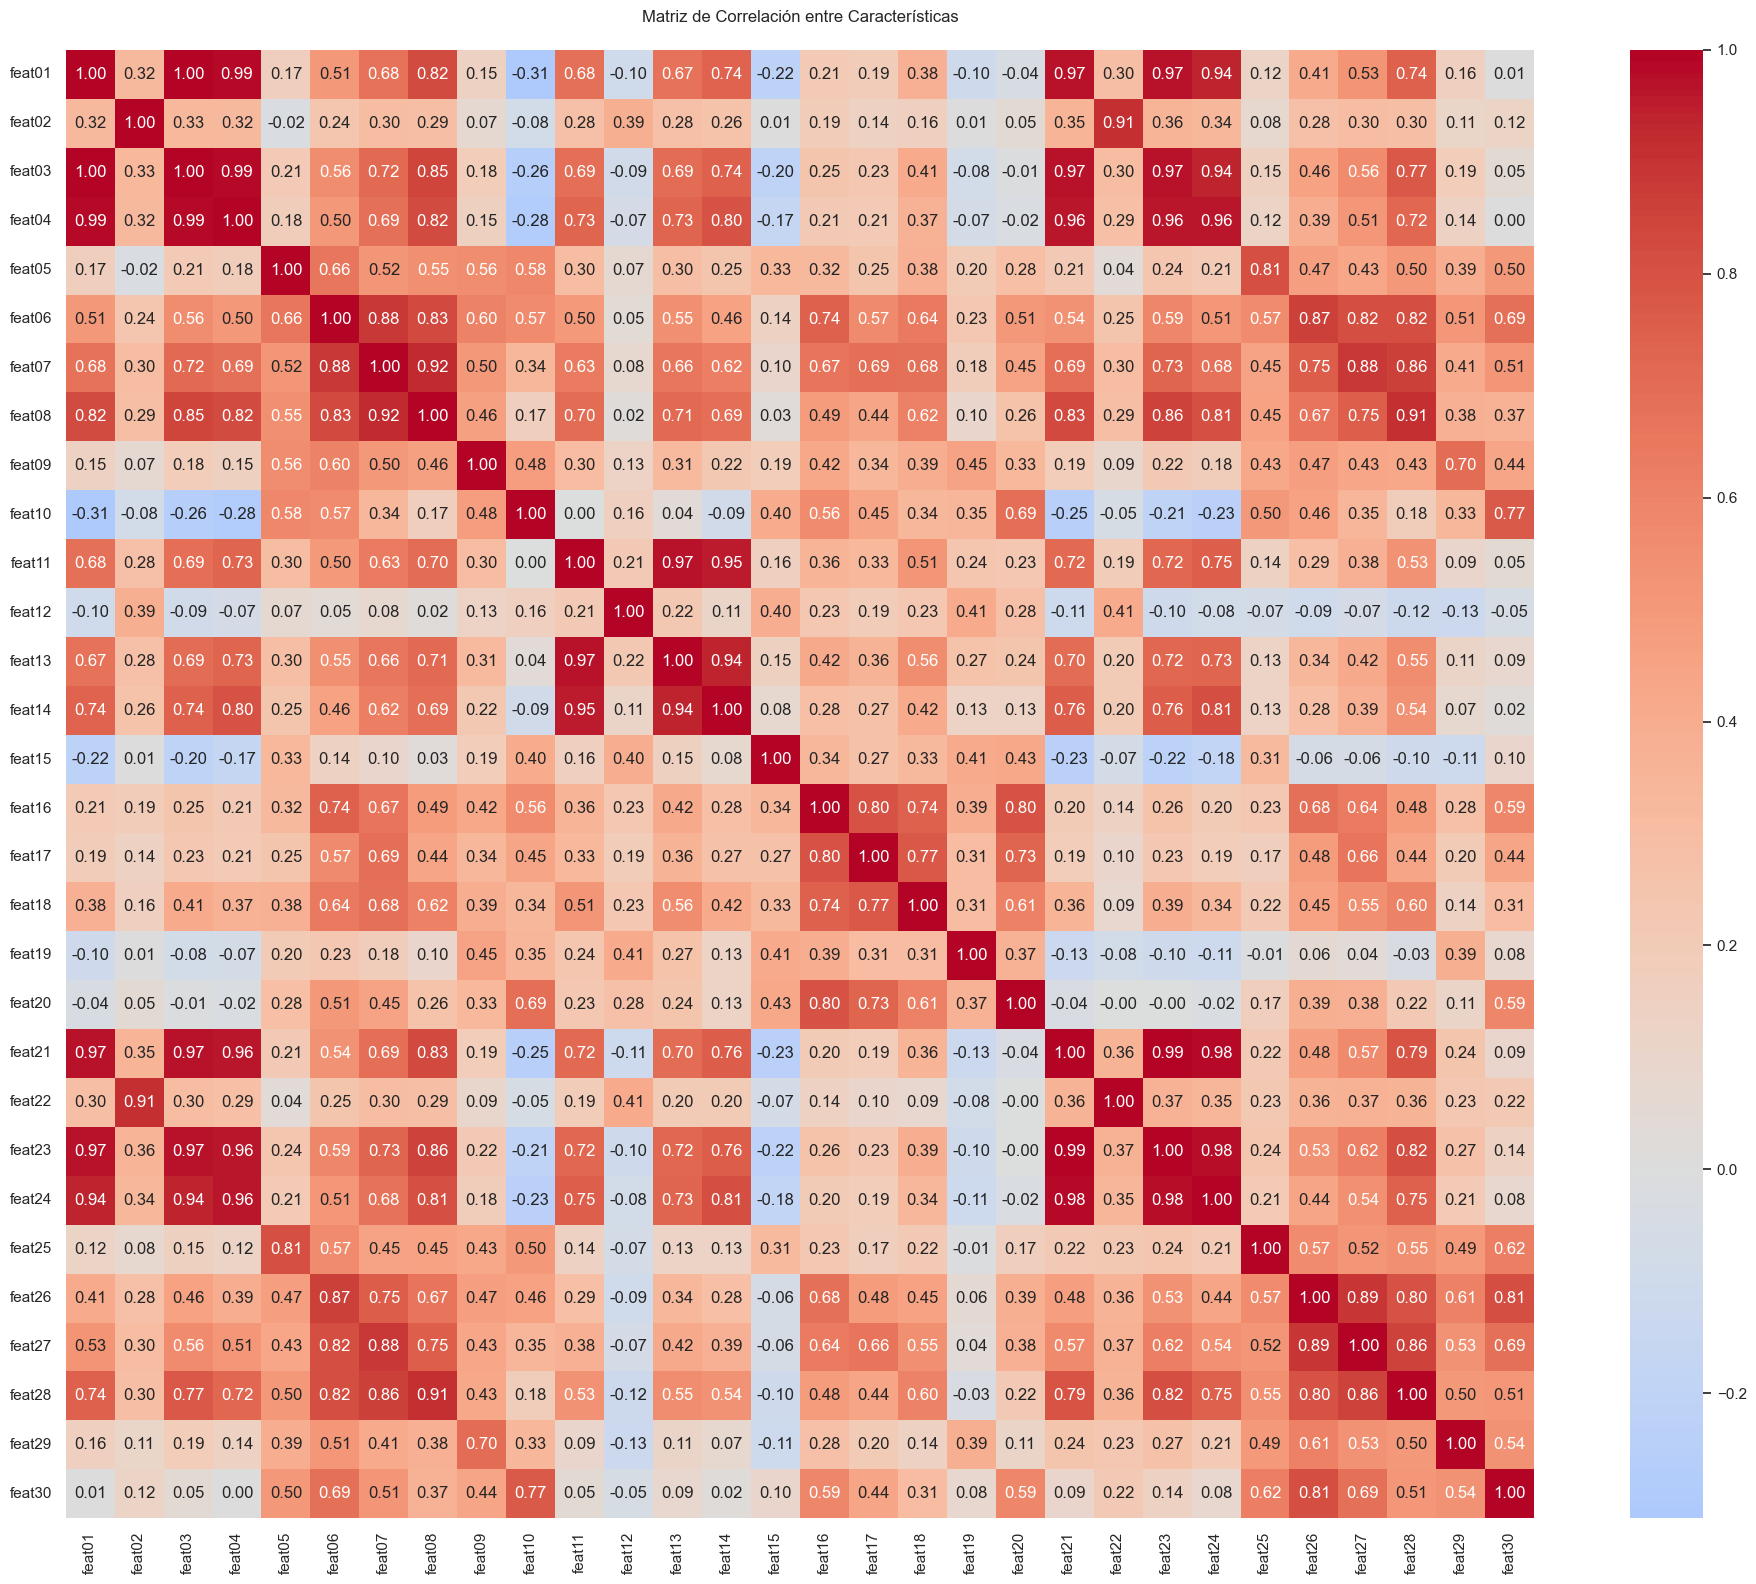

In [8]:
# Calcular correlaciones
correlation_matrix = df_normalized.drop('diagnosis', axis=1).corr()

# Crear la figura con un tamaño específico
plt.figure(figsize=(20, 16))

# Crear el heatmap
sns.heatmap(correlation_matrix, 
            annot=True,          # Mostrar valores
            cmap='coolwarm',     # Esquema de colores
            center=0,            # Centrar el colormap en 0
            fmt='.2f',           # Formato de números
            square=True)         # Hacer que las celdas sean cuadradas

# Ajustar el título y las etiquetas
plt.title('Matriz de Correlación entre Características', pad=20)

# Ajustar los márgenes
plt.tight_layout()

# Guardar el gráfico
plt.savefig('../output/figures/correlation_heatmap.png', 
            dpi=300,            # Alta resolución
            bbox_inches='tight', # Eliminar espacio en blanco extra
            facecolor='white')   # Fondo blanco

# Mostrar el gráfico
plt.show()

## Gráfico de Pares (Pairplot) para las características más relevantes

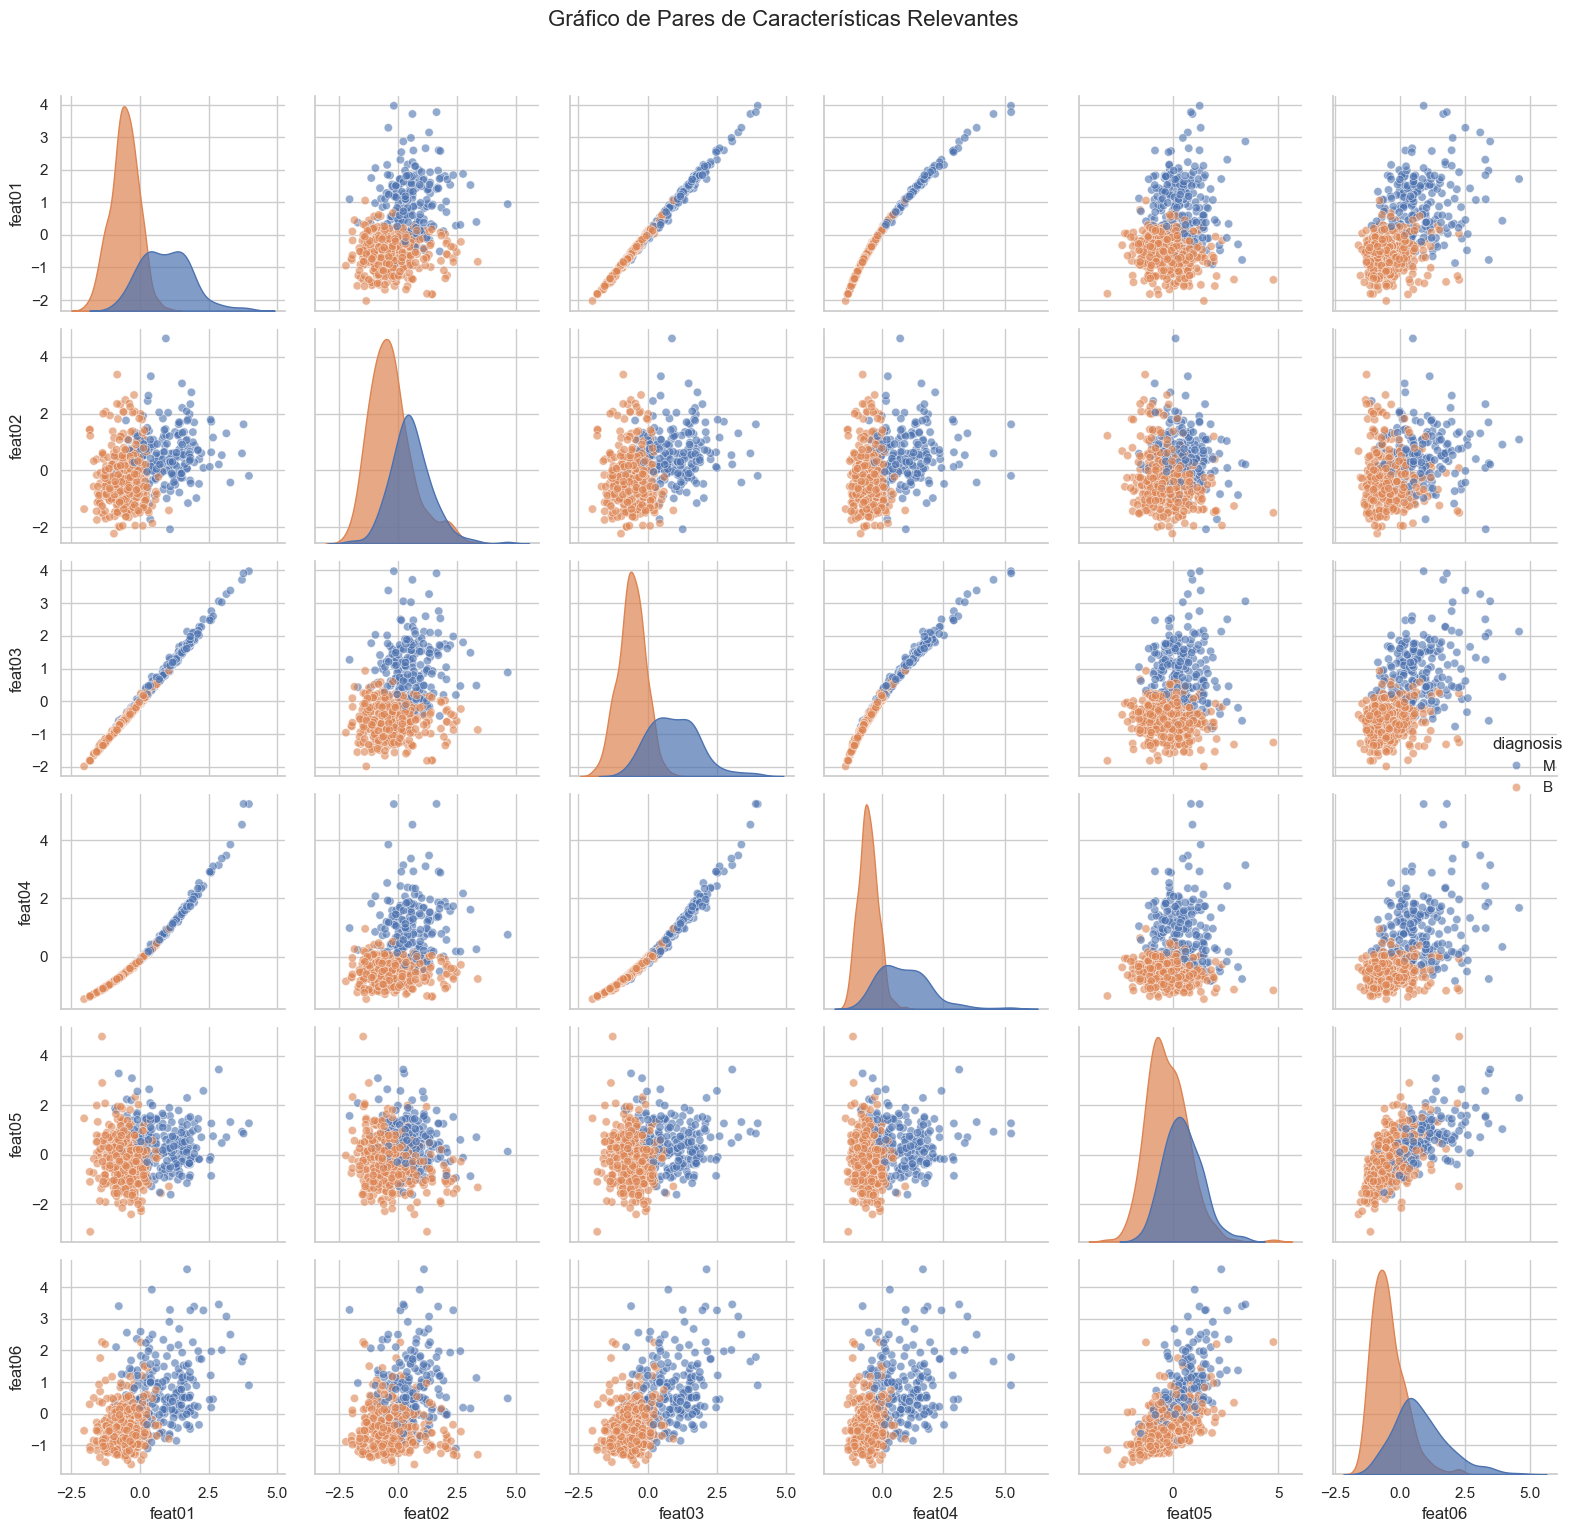

In [9]:
# Seleccionar las características más relevantes
selected_features = ['feat01', 'feat02', 'feat03', 'feat04', 'feat05', 'feat06', 'diagnosis']

# Crear el pairplot
pairplot = sns.pairplot(df_normalized[selected_features], 
                       hue='diagnosis',           # Color según diagnóstico
                       diag_kind='kde',           # Usar KDE en la diagonal
                       plot_kws={'alpha': 0.6},   # Transparencia para puntos
                       diag_kws={'alpha': 0.7})   # Transparencia para KDE

# Ajustar el título
pairplot.fig.suptitle('Gráfico de Pares de Características Relevantes', 
                      y=1.02,     # Ajustar posición vertical del título
                      fontsize=16)

# Ajustar el diseño
plt.tight_layout()

# Guardar el gráfico
pairplot.savefig('../output/figures/pairplot_features.png',
                 dpi=300,             # Alta resolución
                 bbox_inches='tight',  # Eliminar espacio en blanco extra
                 facecolor='white')    # Fondo blanco

# Mostrar el gráfico
plt.show()

## Gráfico Radar (Spider Plot) para comparar perfiles M/B

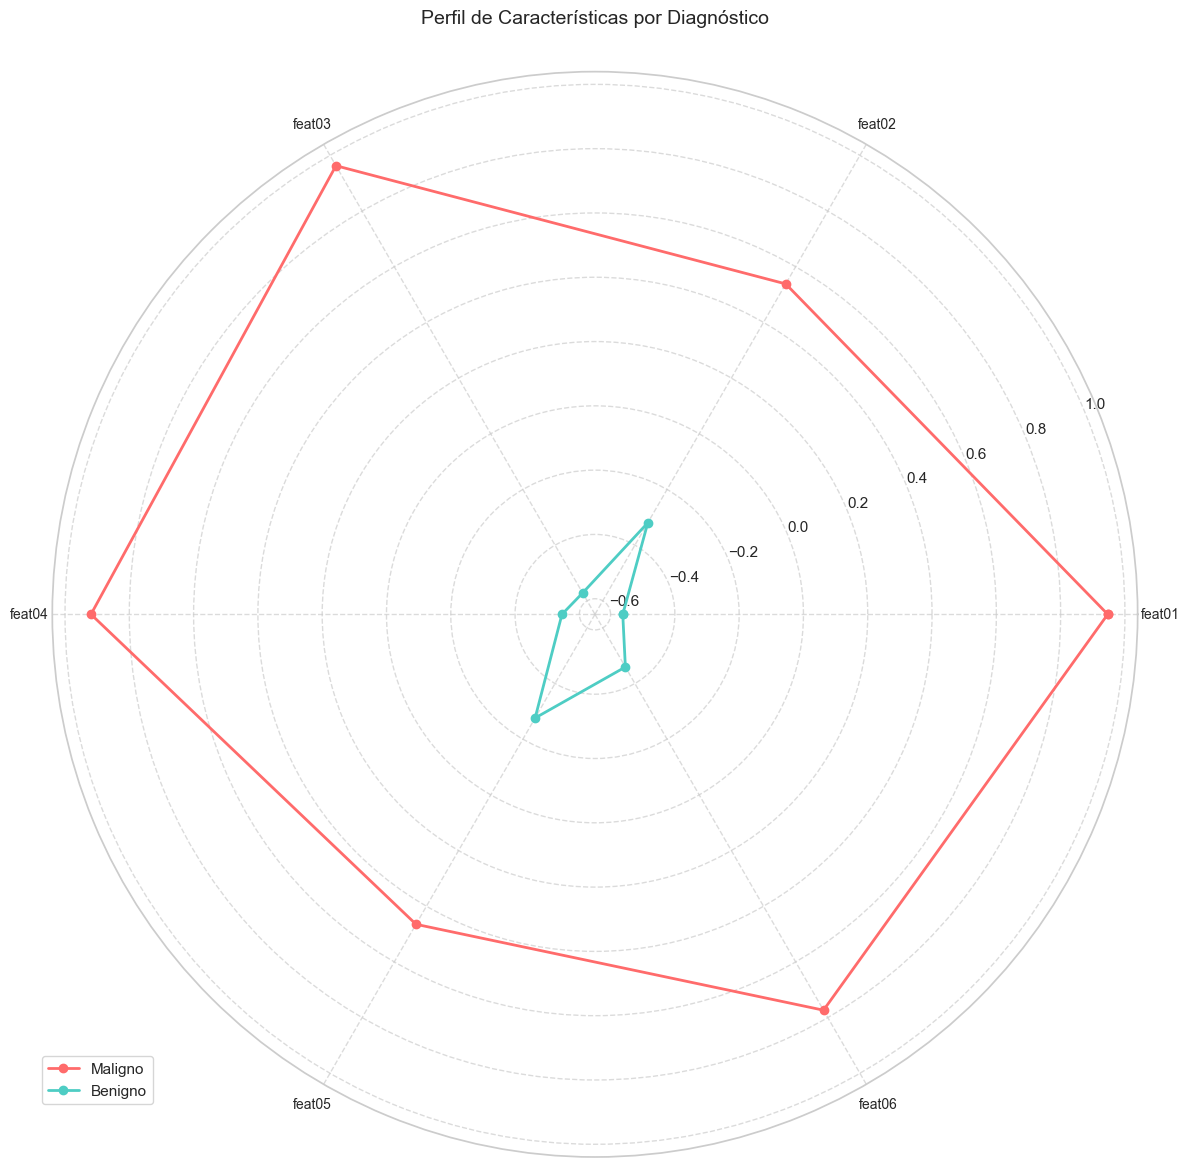

In [10]:
import numpy as np

def radar_plot(df, features):
    # Calcular medias por diagnóstico
    means_M = df[df['diagnosis'] == 'M'][features].mean()
    means_B = df[df['diagnosis'] == 'B'][features].mean()
    
    # Preparar el gráfico
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False)
    
    # Cerrar el gráfico repitiendo el primer valor (usando .iloc para evitar warnings)
    values_M = np.concatenate((means_M.values, [means_M.iloc[0]]))
    values_B = np.concatenate((means_B.values, [means_B.iloc[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    
    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    # Plotear los datos
    ax.plot(angles, values_M, 'o-', linewidth=2, label='Maligno', color='#FF6B6B')
    ax.plot(angles, values_B, 'o-', linewidth=2, label='Benigno', color='#4ECDC4')
    
    # Configurar las etiquetas
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(features, size=10)
    
    # Añadir una cuadrícula
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Añadir leyenda y título
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Perfil de Características por Diagnóstico\n', pad=20, size=14)
    
    # Ajustar el layout
    plt.tight_layout()
    
    # Guardar el gráfico
    plt.savefig('../output/figures/radar_plot.png',
                dpi=300,
                bbox_inches='tight',
                facecolor='white')
    
    # Mostrar el gráfico
    plt.show()

# Usar con las características más relevantes
selected_features = ['feat01', 'feat02', 'feat03', 'feat04', 'feat05', 'feat06']
radar_plot(df_normalized, selected_features)

## Boxplots Agrupados por Característica

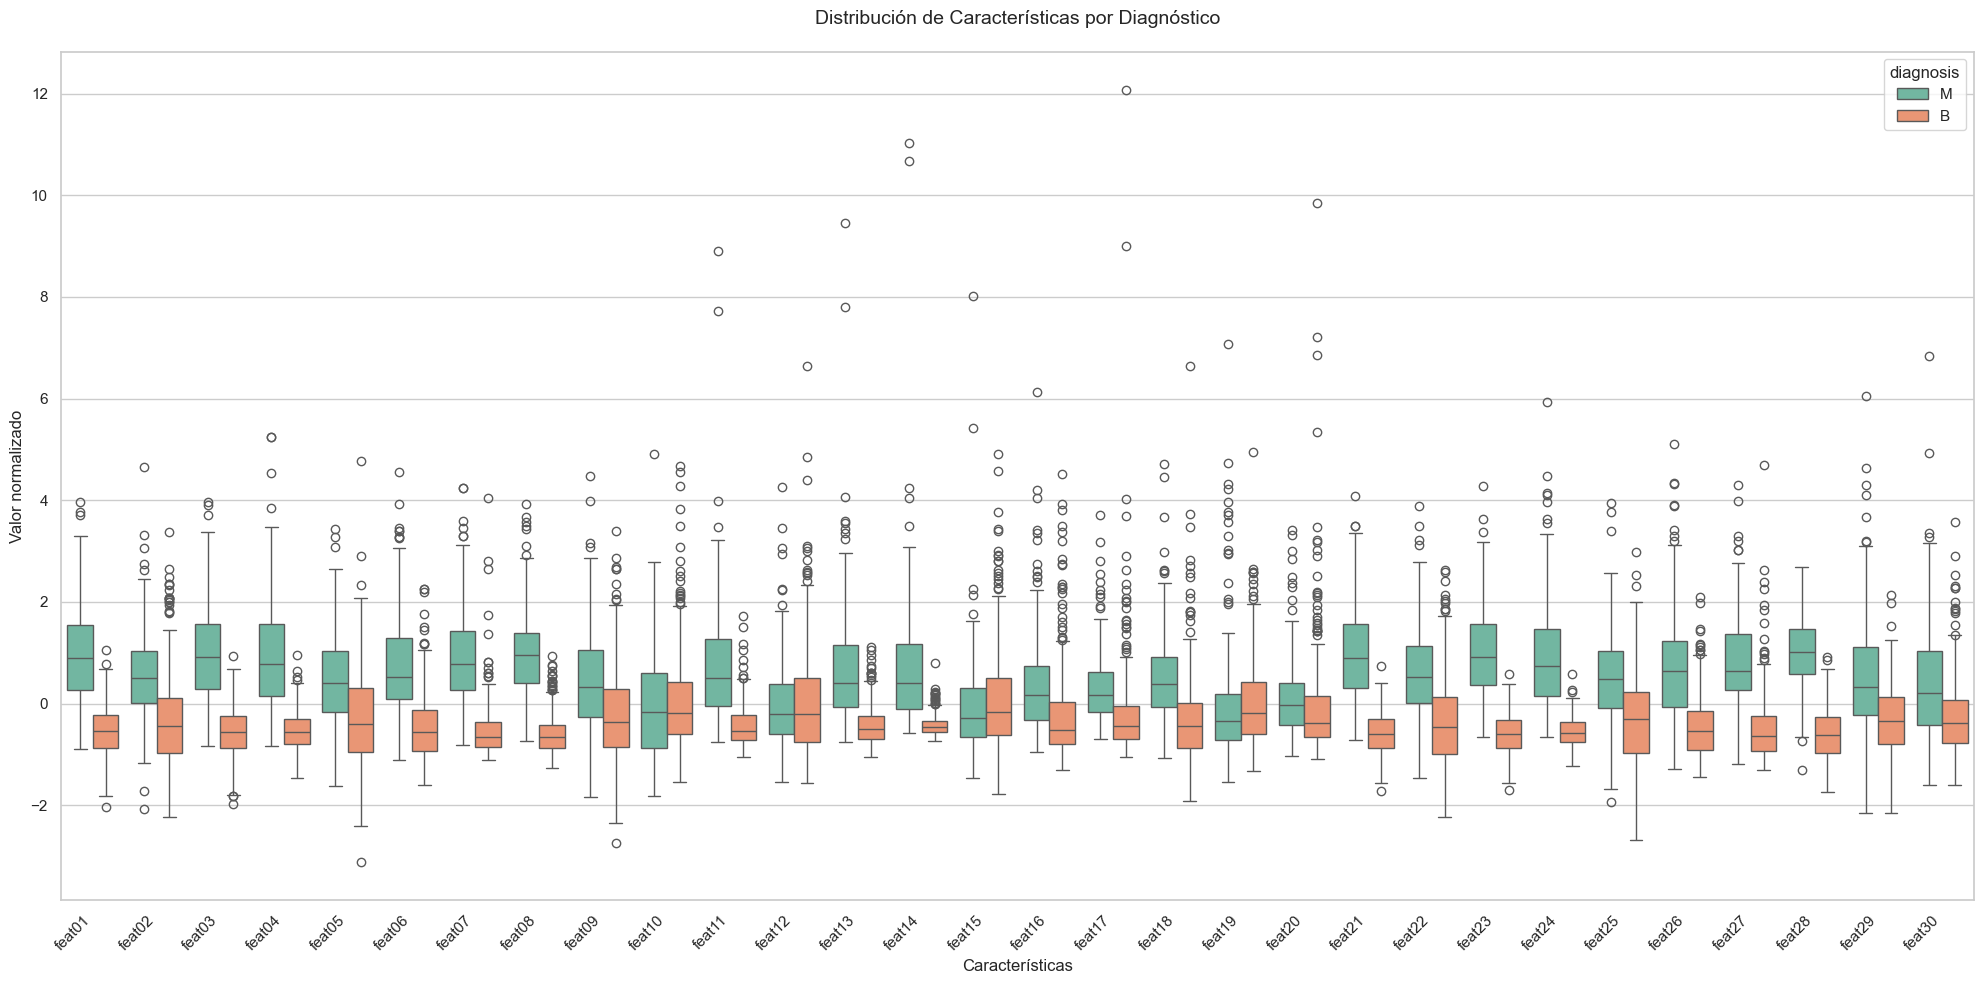

In [11]:
# Crear la figura con un tamaño específico
plt.figure(figsize=(20, 10))

# Crear el boxplot
sns.boxplot(data=df_melted, 
            x='features', 
            y='value',
            hue='diagnosis',
            palette='Set2')

# Configurar el gráfico
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor lectura
plt.title('Distribución de Características por Diagnóstico', pad=20, size=14)
plt.xlabel('Características')
plt.ylabel('Valor normalizado')

# Ajustar los márgenes
plt.tight_layout()

# Guardar el gráfico
plt.savefig('../output/figures/boxplot_features.png',
            dpi=300,            # Alta resolución
            bbox_inches='tight', # Eliminar espacio en blanco extra
            facecolor='white')   # Fondo blanco

# Mostrar el gráfico
plt.show()

## t-SNE o PCA Visualization para ver la separación de clases

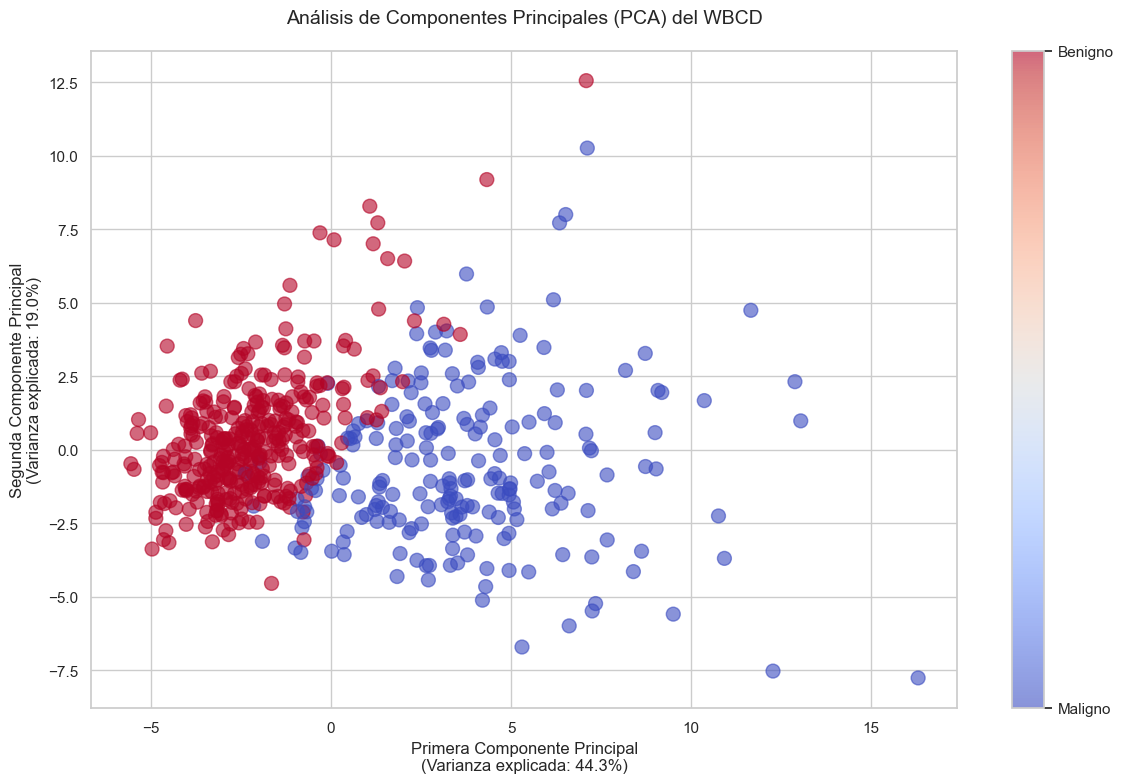

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preparar datos
X = df_normalized.drop('diagnosis', axis=1)
y = df_normalized['diagnosis']

# Aplicar PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Calcular el porcentaje de varianza explicada
var_ratio = pca.explained_variance_ratio_
var_ratio_str = [f"{ratio:.1%}" for ratio in var_ratio]

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Crear scatter plot con colores según diagnóstico
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=y.map({'M': 0, 'B': 1}),
                     cmap='coolwarm',
                     alpha=0.6,
                     s=100)  # Tamaño de los puntos

# Añadir colorbar
colorbar = plt.colorbar(scatter)
colorbar.set_ticks([0, 1])
colorbar.set_ticklabels(['Maligno', 'Benigno'])

# Configurar etiquetas y título
plt.title('Análisis de Componentes Principales (PCA) del WBCD', pad=20, size=14)
plt.xlabel(f'Primera Componente Principal\n(Varianza explicada: {var_ratio_str[0]})')
plt.ylabel(f'Segunda Componente Principal\n(Varianza explicada: {var_ratio_str[1]})')

# Ajustar los márgenes
plt.tight_layout()

# Guardar el gráfico
plt.savefig('../output/figures/pca_visualization.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')

# Mostrar el gráfico
plt.show()

## Gráfico de Barras de Importancia de Características

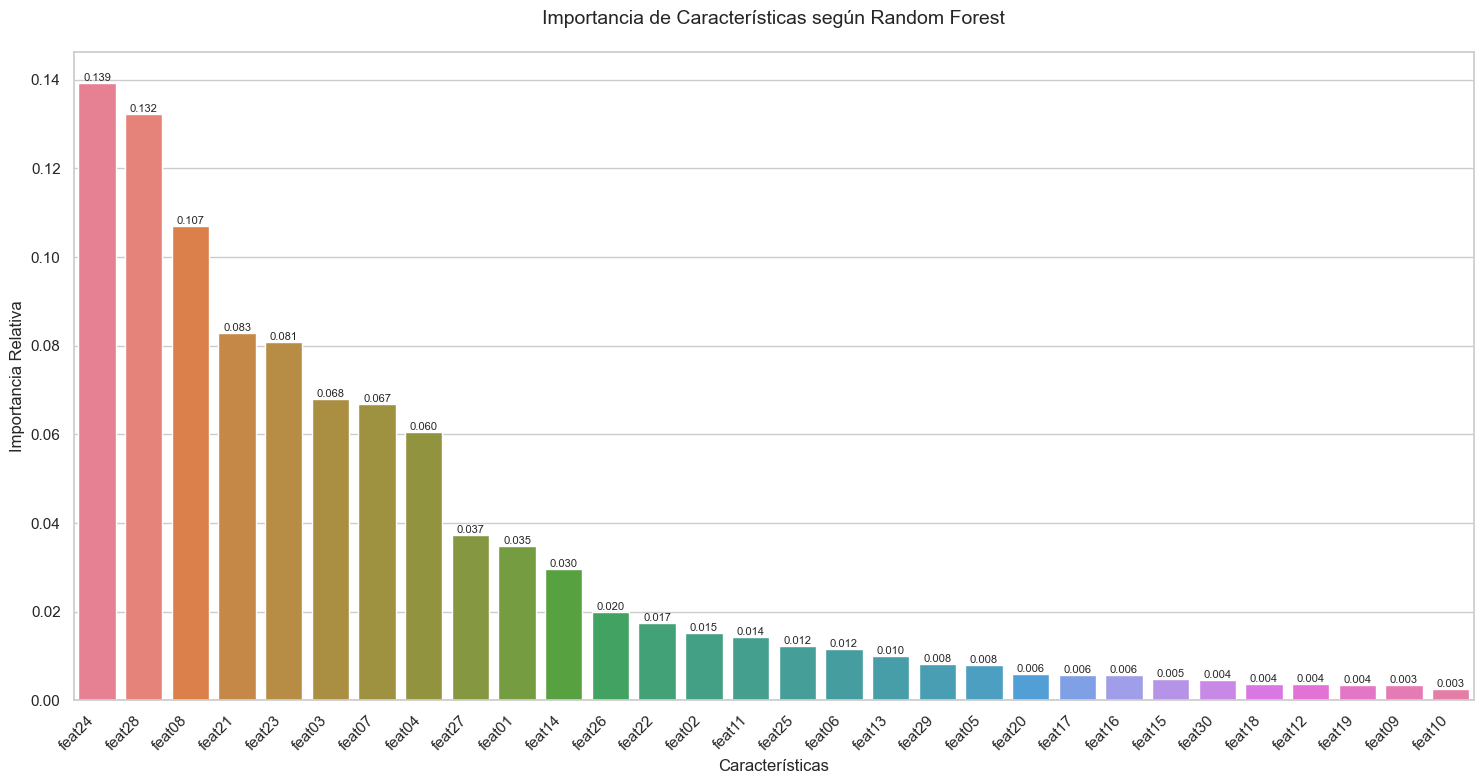

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Preparar los datos
X = df_normalized.drop('diagnosis', axis=1)
y = df_normalized['diagnosis']

# Entrenar un Random Forest para obtener importancia de características
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Crear dataframe con importancias y ordenarlo
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Crear la figura
plt.figure(figsize=(15, 8))

# Crear el gráfico de barras - versión corregida
sns.barplot(data=importance_df, 
            x='feature', 
            y='importance',
            hue='feature',           # Añadido para evitar el warning
            legend=False)            # Ocultar la leyenda ya que no es necesaria

# Configurar el gráfico
plt.xticks(rotation=45, ha='right')
plt.title('Importancia de Características según Random Forest', pad=20, size=14)
plt.xlabel('Características')
plt.ylabel('Importancia Relativa')

# Añadir valores sobre las barras
for i, v in enumerate(importance_df['importance']):
    plt.text(i, v, f'{v:.3f}', 
             ha='center', va='bottom',
             fontsize=8)

# Ajustar los márgenes
plt.tight_layout()

# Guardar el gráfico
plt.savefig('../output/figures/feature_importance.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white')

# Mostrar el gráfico
plt.show()